             0         1         2         3         4         5         6  \
0     0.331695  0.273939  0.308079  0.850027  0.302060  0.446711  0.609034   
1     0.352680  0.284661  0.320602  0.825964  0.315930  0.391377  0.577527   
2     0.327377  0.277557  0.374790  0.892918  0.260643  0.363875  0.585582   
3     0.368138  0.169853  0.299790  0.830238  0.291192  0.356413  0.600144   
4     0.305947  0.173202  0.323763  0.869775  0.245722  0.410799  0.521781   
...        ...       ...       ...       ...       ...       ...       ...   
1995  0.955367  0.900975  0.859499  0.164075  0.771696  0.839762  0.075641   
1996  0.969351  0.906914  0.895709  0.138290  0.797906  0.886112  0.024672   
1997  0.983757  0.942974  0.809635  0.207956  0.899059  0.878931  0.066105   
1998  0.960009  0.869992  0.850273  0.151859  0.834546  0.938914  0.124605   
1999  0.917185  0.838239  0.821459  0.123974  0.794104  0.876168  0.078150   

             7         8         9  
0     0.898889  0.841920  

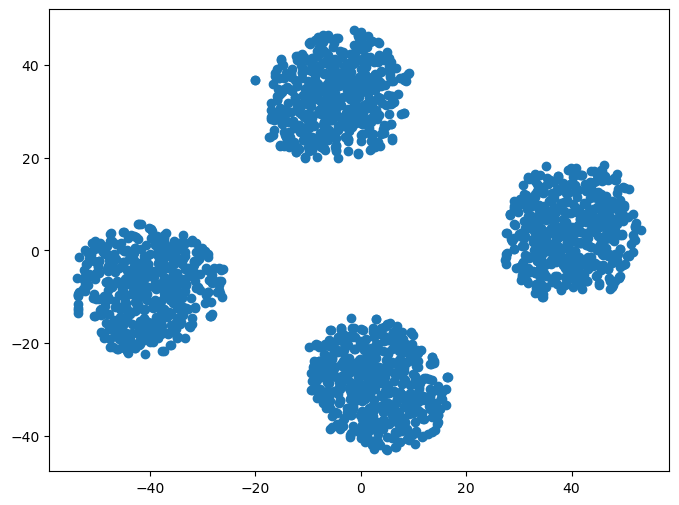

In [2]:
import seaborn as sns
import pandas as pd
import scipy as sp
import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import multivariate_normal
%matplotlib inline

n_cluster = 4
data_dim = 10
num_samples = 500

set_mu = []
set_cov = []

for i in range(1, n_cluster+1):
    mean = np.zeros(data_dim) + i * i
    for j in range(data_dim) :
        mu_j = np.random.choice([-1, 1]) * mean[j]
        mean[j] = mu_j
    set_mu.append(mean)

# 다변량 정규분포 생성
toydata = []
for i in range(n_cluster):
    covariance_matrix = np.diag(np.ones(data_dim))
    mvn = multivariate_normal(mean=set_mu[i], cov=covariance_matrix)
    sample = mvn.rvs(num_samples)
    for s in sample:
        toydata.append(s)
        
scaler = MinMaxScaler()
toydata = pd.DataFrame(toydata)
scaler.fit(toydata)
toydata = scaler.transform(toydata)
toydata = pd.DataFrame(toydata)

class CustomDataset(Dataset):
    def __init__(self, csv):
        self.inp = csv.values
        lables = []
        for i in range(n_cluster) :
            for j in range(num_samples):
                lables.append(i)
        lables = pd.DataFrame(lables)
        self.lable = lables.values

    def __len__(self):
        return len(self.inp) 

    def __getitem__(self,idx):
        inp = torch.FloatTensor(self.inp[idx])
        lable = torch.LongTensor(self.lable[idx])
        return inp, lable
    
dataset = CustomDataset(toydata)
dataloader = DataLoader(dataset, batch_size=500, shuffle=True)
# for x in dataloader :
#     print(x)

tsne = TSNE(n_components=2, random_state=20)
X_tsne = tsne.fit_transform(toydata)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])

print(toydata)

In [3]:
pip install easydict

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [11]:
import argparse
from sklearn.mixture import GaussianMixture
import torch
import torch.nn.functional as F
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import easydict
from vade import AutoEncoderForPretrain, VaDE
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

N_CLASSES = 4
data_dim = 10
lat_dim = 2


def train(model, dataloader, optimizer, device, epoch):

    total_loss = 0
    for x,_ in dataloader:
        batch_size = x.size(0)
        x = x.to(device).view(-1, data_dim)
        recon_x = model(x)
        loss = F.binary_cross_entropy(recon_x, x, reduction='sum') / batch_size
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch {:>3}: Train Loss = {:.4f}'.format(
        epoch, total_loss / len(dataloader)))


args = easydict.EasyDict ({
    "epochs" : 20,
    "gpu" : -1,
    "batch_size" : 50,
    "learning_rate" : 0.001,
    "out" : './vade_parameter_toy.pth'
})

if_use_cuda = torch.cuda.is_available() and args.gpu >= 0
device = torch.device('cuda:{}'.format(args.gpu) if if_use_cuda else 'cpu')

pretrain_model = AutoEncoderForPretrain(data_dim, 2).to(device)

optimizer = torch.optim.Adam(pretrain_model.parameters(),
                             lr=args.learning_rate)

for epoch in range(1, args.epochs + 1):
    train(pretrain_model, dataloader, optimizer, device, epoch)

with torch.no_grad():
    x = torch.vstack([data[0] for data in dataset]).view(-1, data_dim).to(device)
    z = pretrain_model.encode(x).cpu()

pretrain_model = pretrain_model.cpu()
state_dict = pretrain_model.state_dict()

gmm = GaussianMixture(n_components=4, covariance_type='diag')
gmm.fit(z)

model = VaDE(N_CLASSES, data_dim, lat_dim)
model.load_state_dict(state_dict, strict=False)
model._pi.data = torch.log(torch.from_numpy(gmm.weights_)).float()
model.mu.data = torch.from_numpy(gmm.means_).float()
model.logvar.data = torch.log(torch.from_numpy(gmm.covariances_)).float()

torch.save(model.state_dict(), args.out)




Epoch   1: Train Loss = 6.8899
Epoch   2: Train Loss = 6.6899
Epoch   3: Train Loss = 6.2483
Epoch   4: Train Loss = 5.7231
Epoch   5: Train Loss = 5.6050
Epoch   6: Train Loss = 5.4463
Epoch   7: Train Loss = 5.3311
Epoch   8: Train Loss = 5.2373
Epoch   9: Train Loss = 5.1885
Epoch  10: Train Loss = 5.1960
Epoch  11: Train Loss = 5.1808
Epoch  12: Train Loss = 5.1583
Epoch  13: Train Loss = 5.1454
Epoch  14: Train Loss = 5.1283
Epoch  15: Train Loss = 5.1080
Epoch  16: Train Loss = 5.1005
Epoch  17: Train Loss = 5.1012
Epoch  18: Train Loss = 5.0980
Epoch  19: Train Loss = 5.0975
Epoch  20: Train Loss = 5.0977


In [12]:
import argparse
import matplotlib.pyplot as plt
from munkres import Munkres
from sklearn.manifold import TSNE
import torch
import torch.utils.data
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import easydict
from vade import VaDE, lossfun, ordloss 

N_CLASSES = 4
data_dim = 10
PLOT_NUM_PER_CLASS = 128


def train(model, data_dim, data_loader, optimizer, device, epoch, writer):

    total_loss = 0
    for x,_ in data_loader:
        x = x.to(device).view(-1, data_dim)
        recon_x, mu, logvar = model(x)    ###forward 자동호출
        loss = lossfun(model, x, recon_x, mu, logvar)
        #ord_loss = (ordloss(model, x, 10,2))/20
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    writer.add_scalar('Loss/train', total_loss / len(data_loader), epoch)
    print('Epoch {:>3}: Train Loss = {:.4f}'.format(
        epoch, total_loss / len(data_loader)))


def test(model, data_dim, data_loader, device, epoch, plot_points, writer):
    model.eval()

    gain = torch.zeros((N_CLASSES, N_CLASSES), dtype=torch.int, device=device)
    with torch.no_grad():
        for xs, ts in data_loader:
            xs, ts = xs.to(device).view(-1, data_dim), ts.to(device).squeeze()
            ys = model.classify(xs)
            for t, y in zip(ts, ys):
                gain[t, y] += 1
        cost = (torch.max(gain) - gain).cpu().numpy()
        assign = Munkres().compute(cost)
        acc = torch.sum(gain[tuple(zip(*assign))]).float() / torch.sum(gain)
        # Plot latent space
        xs, ts = plot_points[0].to(device), plot_points[1].numpy()
        zs = model.encode(xs)[0].cpu().numpy()
        fig, ax = plt.subplots()
        cmap = plt.get_cmap("tab10")
        for t in range(N_CLASSES):
            points = zs[ts == t]
            ax.scatter(points[:, 0], points[:, 1], color=cmap(t), label=str(t))
        ax.legend()
    print('Accuracy = {:.4f}'.format(acc))

    writer.add_scalar('Acc/test', acc.item(), epoch)
    writer.add_figure('LatentSpace', fig, epoch)



args = easydict.EasyDict ({
    "epochs" : 200,
    "gpu" : 0,
    "learning_rate" : 0.002,
    "batch_size" : 500,
    "pretrain" : './vade_parameter_toy.pth'
})

if_use_cuda = torch.cuda.is_available() and args.gpu >= 0
device = torch.device('cuda:{}'.format(args.gpu) if if_use_cuda else 'cpu')

# For plotting
plot_points = {}
for t in range(N_CLASSES):
    points = torch.cat([data for data, label in dataset if label == t])
    points = points.view(-1, data_dim).to(device)
    plot_points[t] = points
xs = []
ts = []
for t, x in plot_points.items():
    xs.append(x)
    t = torch.full((x.size(0),), t, dtype=torch.long)
    ts.append(t)
plot_points = (torch.cat(xs, dim=0), torch.cat(ts, dim=0))

model = VaDE(N_CLASSES, data_dim, 2)
if args.pretrain:
    model.load_state_dict(torch.load(args.pretrain))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
# LR decreases every 10 epochs with a decay rate of 0.9
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=10, gamma=0.9)

# TensorBoard
writer = SummaryWriter()
for epoch in range(1, args.epochs + 1):
    train(model, data_dim, dataloader, optimizer, device, epoch, writer)
    test(model, data_dim, dataloader, device, epoch, plot_points, writer)
    lr_scheduler.step()

writer.close()


# for t in range(6):
#     points = zs[ts == t]
#     plt.scatter(points[:, 0], points[:, 1], color=cmap(t), label=str(t))


RuntimeError: all elements of input should be between 0 and 1

[[0.23814002 0.20583996]
 [0.2390055  0.20541121]
 [0.23811293 0.20585337]
 ...
 [0.2659847  0.19204591]
 [0.2676131  0.1912392 ]
 [0.26654905 0.19176634]]
[1784, 216, 0, 0]
Parameter containing:
tensor([[ 0.2282,  0.2093],
        [ 0.2535,  0.2063],
        [ 0.2337,  0.2055],
        [-0.3524,  0.2071]], requires_grad=True)


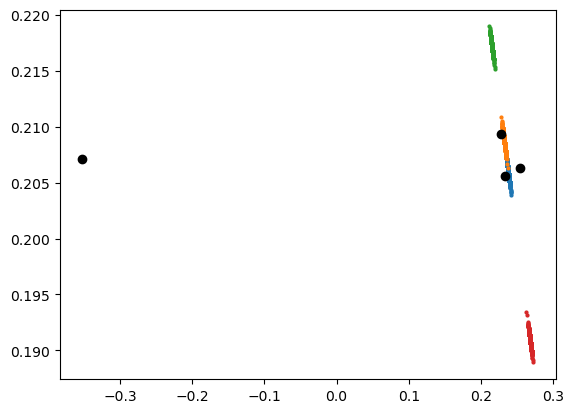

In [22]:
xs, ts = plot_points[0].to(device), plot_points[1].numpy()
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    z = mu + eps * 0
    return z

z_mu = model.encode(xs)[0]
z_var= model.encode(xs)[1]
z = reparameterize(z_mu, z_var).detach().numpy()

print(z)
pr = model.classify(xs)

### 지정 cluster 개수 
result=[]
for t in range(4):
    num = 0 
    for a in pr:
        if a==t:
            num += 1
    result.append(num)

print(result)
print(model.mu)
cmap = plt.get_cmap("tab10")
for d,l,p in zip(xs, ts, z) :
    plt.scatter(p[0], p[1], color = cmap(l), s = 4)

mu_result = model.mu.detach().numpy()
plt.scatter(mu_result[:,0], mu_result[:,1], color = 'black')

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir=runs 